# PyTorch: Aprendiendo Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.1)

import os
import pickle
import datetime
from collections import defaultdict

In [2]:
# 1.2)

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [3]:
# 1.3)

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [4]:
# 1.4)
#import google.colab
#from google.colab import files

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores al rango [0,1]) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [4]:
# 2.1)

PATH = 'FashionMNIST/'
BATCH_SIZE = 64

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  
])

train_data = datasets.FashionMNIST(PATH, train=True, download=True, transform=transform)
valid_data = datasets.FashionMNIST(PATH,train=False, download=True, transform=transform)

In [6]:
len(train_data), len(valid_data)

(60000, 10000)

In [8]:
img_t, _ = train_data[0]

In [9]:
imgs = torch.stack([img_t for img_t, _ in train_data], dim=1)
imgs.shape

torch.Size([1, 60000, 28, 28])

In [9]:
imgs.view(1, -1).mean(dim=1)

tensor([0.0001])

In [10]:
imgs.view(1, -1).std(dim=1)

tensor([1.0001])

In [5]:
trainloader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

validloader = torch.utils.data.DataLoader(valid_data, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True)

In [10]:
imgs, label = train_data[0]

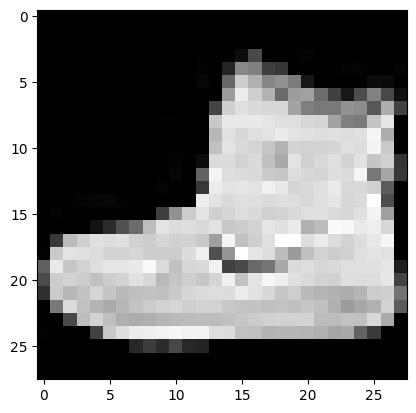

In [11]:
plt.imshow(imgs.squeeze(), cmap='gray')

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss

https://ryanwingate.com/intro-to-machine-learning/deep-learning-with-pytorch/classifying-fashion-mnist/

Deep Learning with PyTorch, Capitulo 7

In [6]:
labels_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

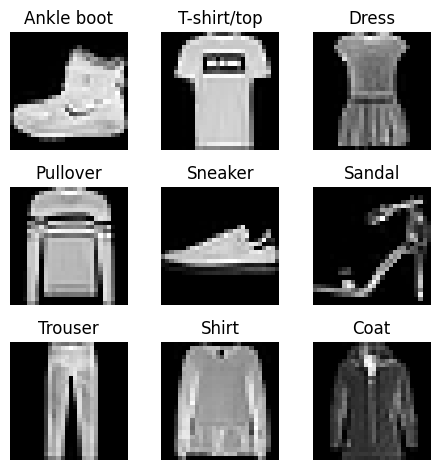

In [7]:
figure = plt.figure()
cols, rows = 3,3

# Guardar etiquetas que ya hemos añadido
selected_labels = set()

for i in range(1, cols*rows+1):
    for j, (image, label) in enumerate(train_data):
        if label not in selected_labels:  # Si la etiqueta no ha sido seleccionada
            selected_labels.add(label)
            figure.add_subplot(rows, cols, i)
            plt.title(labels_names[label])
            plt.axis('off')
            plt.imshow(image.squeeze(), cmap='gray')
            break  # Pasar al siguiente espacio de la grilla
plt.tight_layout()
plt.tight_layout()
plt.tight_layout()
plt.tight_layout()
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [7]:
# 3.1)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=100, shuffle=False)

In [8]:
# 3.2)

len(train_loader.dataset), len(train_loader)

(60000, 600)

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [5]:
# 4)

class NeuralNetwork(nn.Module):
    def __init__(self, n1, n2, p=0.2):
        super(NeuralNetwork, self).__init__()
        # Capa 0
        self.flatten = nn.Flatten()     #2d a 1d
        
        # Capa 1
        self.fc1 = nn.Linear(28*28, n1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

        # Capa 2
        self.fc2 = nn.Linear(n1, n2)

        # Capa 3        
        self.fc3 = nn.Linear(n2, 10)

    def forward(self, x):
        # Capa 0
        x = self.flatten(x)

        # Capa 1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Capa 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Capa 3
        x = self.fc3(x)
        return x

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [6]:
# Eligiendo dispositivo (se puede cambiar en notebook settings)
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU disponible")
else:
    device = torch.device("cpu")
    print("GPU no disponible, usando CPU")

GPU no disponible, usando CPU


In [7]:
# 5.1)
def train_model(dataloader, model, loss_fn, optimizer):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        num_processed_samples += batch_size

        if batch % max(num_batches // 10, 1) == 0:
            print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | '
                  f'Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

# 5.2)
def valid_model(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            sum_batch_avrg_loss += loss.item()
            sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    print(f'Validation | Precision: {100 * precision:.1f}% | Avg Loss: {avg_loss:.6f}')
    return avg_loss, precision

In [8]:
PATH = 'FashionMNIST/'
BATCH_SIZE = 100

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(PATH, train=True, download=True, transform=transform)
valid_data = datasets.FashionMNIST(PATH,train=False, download=True, transform=transform)

In [ ]:
# 5.3)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)


# 5.4)
loss_fn = nn.CrossEntropyLoss()


# 5.5)
lr = 1e-3


# 5.6)
n1 = 128
n2 = 64
p = 0.2
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# 5.7)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 5.9)
num_epochs = 30
list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

Epoch 1
--------------------
Batch     0 | Loss: 2.310755 | Processed: 0.17%
Batch    60 | Loss: 2.310436 | Processed: 10.17%
Batch   120 | Loss: 2.275797 | Processed: 20.17%
Batch   180 | Loss: 2.263586 | Processed: 30.17%
Batch   240 | Loss: 2.228400 | Processed: 40.17%
Batch   300 | Loss: 2.230988 | Processed: 50.17%
Batch   360 | Loss: 2.196864 | Processed: 60.17%
Batch   420 | Loss: 2.204342 | Processed: 70.17%
Batch   480 | Loss: 2.191338 | Processed: 80.17%
Batch   540 | Loss: 2.163118 | Processed: 90.17%
Validation | Precision: 40.2% | Avg Loss: 2.125742
Validation | Precision: 40.4% | Avg Loss: 2.126325
Epoch 2
--------------------
Batch     0 | Loss: 2.151825 | Processed: 0.17%
Batch    60 | Loss: 2.101152 | Processed: 10.17%
Batch   120 | Loss: 2.098765 | Processed: 20.17%
Batch   180 | Loss: 2.071073 | Processed: 30.17%
Batch   240 | Loss: 2.044853 | Processed: 40.17%
Batch   300 | Loss: 2.018489 | Processed: 50.17%
Batch   360 | Loss: 1.965703 | Processed: 60.17%
Batch   4

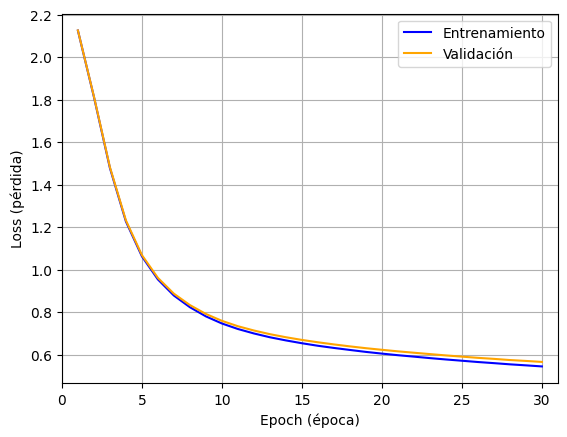

In [48]:
# 5.10)

plt.xlabel('Epoch (época)')
plt.ylabel('Loss (pérdida)')

plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")


plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

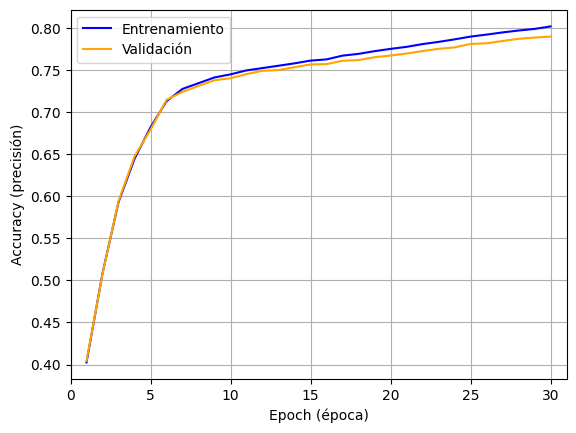

In [49]:
plt.xlabel('Epoch (época)')
plt.ylabel('Accuracy (precisión)')

plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")

plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

## Cambiamos parámetros

Epoch 1
--------------------
Batch     0 | Loss: 2.312763 | Processed: 0.17%
Batch    60 | Loss: 0.735883 | Processed: 10.17%
Batch   120 | Loss: 0.506201 | Processed: 20.17%
Batch   180 | Loss: 0.636274 | Processed: 30.17%
Batch   240 | Loss: 0.513015 | Processed: 40.17%
Batch   300 | Loss: 0.631756 | Processed: 50.17%
Batch   360 | Loss: 0.466332 | Processed: 60.17%
Batch   420 | Loss: 0.588910 | Processed: 70.17%
Batch   480 | Loss: 0.440824 | Processed: 80.17%
Batch   540 | Loss: 0.503293 | Processed: 90.17%
Validation | Precision: 85.1% | Avg Loss: 0.404198
Validation | Precision: 83.7% | Avg Loss: 0.437537
Epoch 2
--------------------
Batch     0 | Loss: 0.450528 | Processed: 0.17%
Batch    60 | Loss: 0.375600 | Processed: 10.17%
Batch   120 | Loss: 0.382668 | Processed: 20.17%
Batch   180 | Loss: 0.408403 | Processed: 30.17%
Batch   240 | Loss: 0.372628 | Processed: 40.17%
Batch   300 | Loss: 0.321205 | Processed: 50.17%
Batch   360 | Loss: 0.380906 | Processed: 60.17%
Batch   4

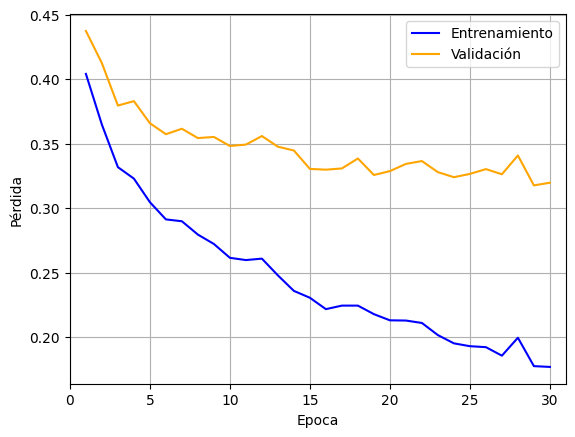

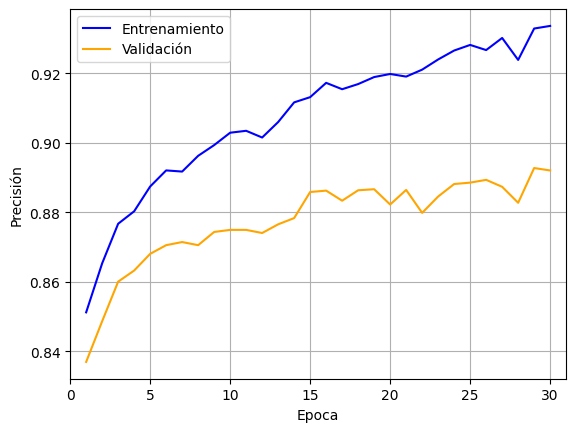

In [68]:
#Cambiamos el optimizador a Adam
lr = 1e-3
n1 = 128
n2 = 64
p = 0.2
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.306825 | Processed: 0.17%
Batch    60 | Loss: 2.272317 | Processed: 10.17%
Batch   120 | Loss: 2.281751 | Processed: 20.17%
Batch   180 | Loss: 2.237358 | Processed: 30.17%
Batch   240 | Loss: 2.210272 | Processed: 40.17%
Batch   300 | Loss: 2.221804 | Processed: 50.17%
Batch   360 | Loss: 2.196376 | Processed: 60.17%
Batch   420 | Loss: 2.182349 | Processed: 70.17%
Batch   480 | Loss: 2.143045 | Processed: 80.17%
Batch   540 | Loss: 2.104336 | Processed: 90.17%
Validation | Precision: 38.1% | Avg Loss: 2.091997
Validation | Precision: 38.3% | Avg Loss: 2.091626
Epoch 2
--------------------
Batch     0 | Loss: 2.083805 | Processed: 0.17%
Batch    60 | Loss: 2.057334 | Processed: 10.17%
Batch   120 | Loss: 2.080956 | Processed: 20.17%
Batch   180 | Loss: 2.052246 | Processed: 30.17%
Batch   240 | Loss: 1.987340 | Processed: 40.17%
Batch   300 | Loss: 1.974281 | Processed: 50.17%
Batch   360 | Loss: 1.987588 | Processed: 60.17%
Batch   4

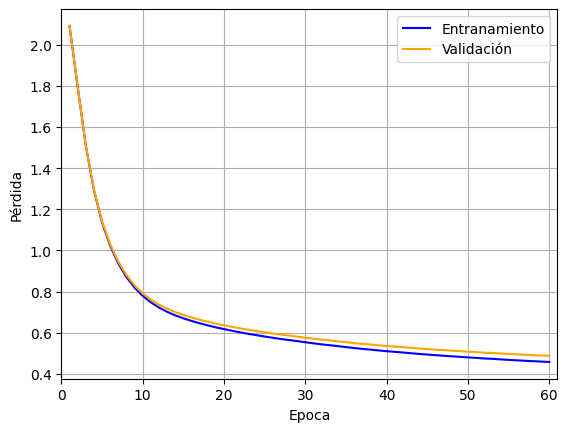

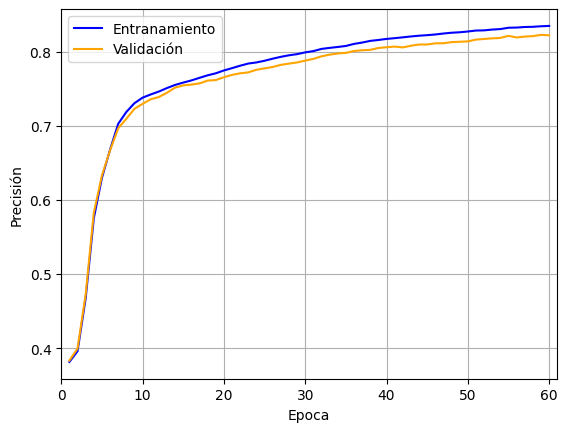

In [ ]:
# Aumentamos el numero de epocas 

lr = 1e-3
n1 = 128
n2 = 64
p = 0.2
BATCH_SIZE = 100
num_epochs = 60

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')


plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 61)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 61)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


Epoch 1
--------------------
Batch     0 | Loss: 2.284874 | Processed: 0.17%
Batch    60 | Loss: 2.156951 | Processed: 10.17%
Batch   120 | Loss: 1.843359 | Processed: 20.17%
Batch   180 | Loss: 1.580859 | Processed: 30.17%
Batch   240 | Loss: 1.249177 | Processed: 40.17%
Batch   300 | Loss: 1.180192 | Processed: 50.17%
Batch   360 | Loss: 1.152466 | Processed: 60.17%
Batch   420 | Loss: 1.090970 | Processed: 70.17%
Batch   480 | Loss: 0.994882 | Processed: 80.17%
Batch   540 | Loss: 0.891795 | Processed: 90.17%
Validation | Precision: 74.6% | Avg Loss: 0.738800
Validation | Precision: 73.9% | Avg Loss: 0.752862
Epoch 2
--------------------
Batch     0 | Loss: 0.931437 | Processed: 0.17%
Batch    60 | Loss: 0.713912 | Processed: 10.17%
Batch   120 | Loss: 0.718121 | Processed: 20.17%
Batch   180 | Loss: 0.657403 | Processed: 30.17%
Batch   240 | Loss: 0.796581 | Processed: 40.17%
Batch   300 | Loss: 0.756684 | Processed: 50.17%
Batch   360 | Loss: 0.827109 | Processed: 60.17%
Batch   4

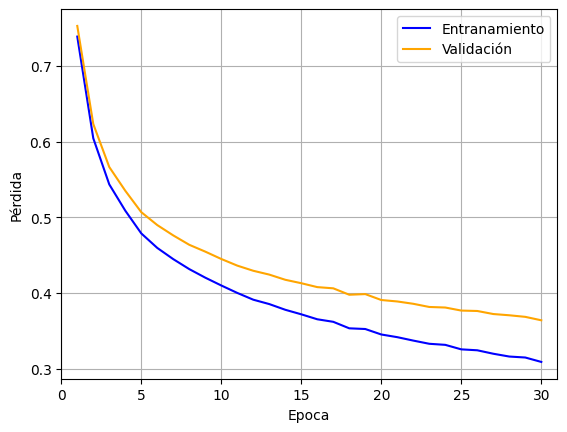

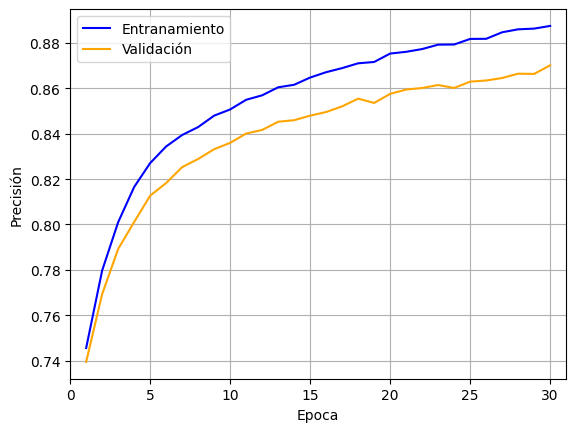

In [ ]:
# Cambiamos el learning rate a 1e-2

lr = 1e-2
n1 = 128
n2 = 64
p = 0.2
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

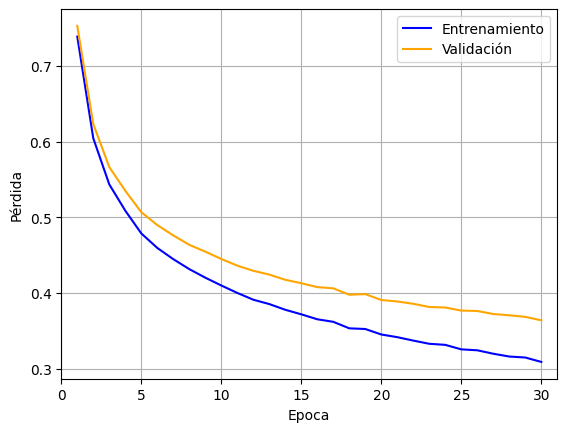

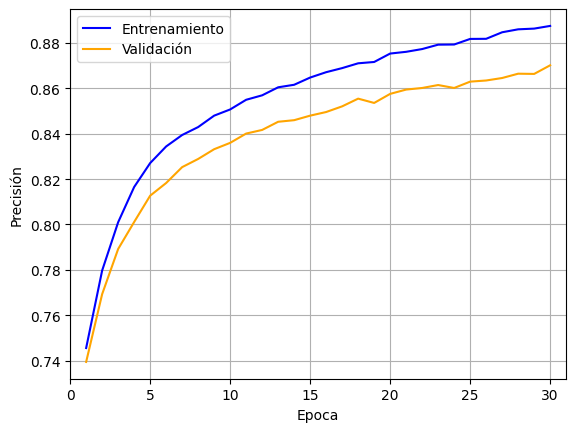

In [42]:
plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.327339 | Processed: 0.17%
Batch    60 | Loss: 0.972396 | Processed: 10.17%
Batch   120 | Loss: 0.937970 | Processed: 20.17%
Batch   180 | Loss: 0.643828 | Processed: 30.17%
Batch   240 | Loss: 0.829316 | Processed: 40.17%
Batch   300 | Loss: 0.619640 | Processed: 50.17%
Batch   360 | Loss: 0.465573 | Processed: 60.17%
Batch   420 | Loss: 0.540809 | Processed: 70.17%
Batch   480 | Loss: 0.521632 | Processed: 80.17%
Batch   540 | Loss: 0.400426 | Processed: 90.17%
Validation | Precision: 83.3% | Avg Loss: 0.449940
Validation | Precision: 82.1% | Avg Loss: 0.478726
Epoch 2
--------------------
Batch     0 | Loss: 0.510433 | Processed: 0.17%
Batch    60 | Loss: 0.521623 | Processed: 10.17%
Batch   120 | Loss: 0.675987 | Processed: 20.17%
Batch   180 | Loss: 0.460581 | Processed: 30.17%
Batch   240 | Loss: 0.390286 | Processed: 40.17%
Batch   300 | Loss: 0.418236 | Processed: 50.17%
Batch   360 | Loss: 0.532308 | Processed: 60.17%
Batch   4

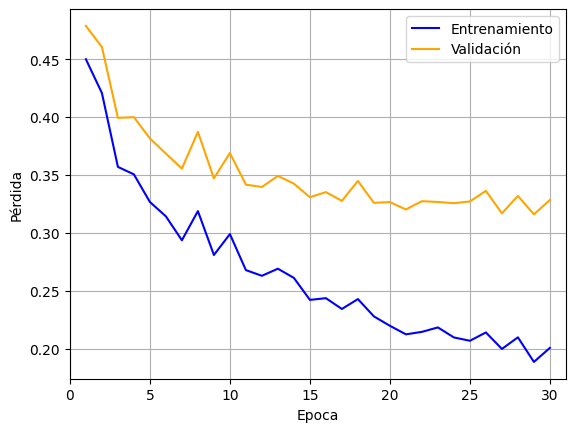

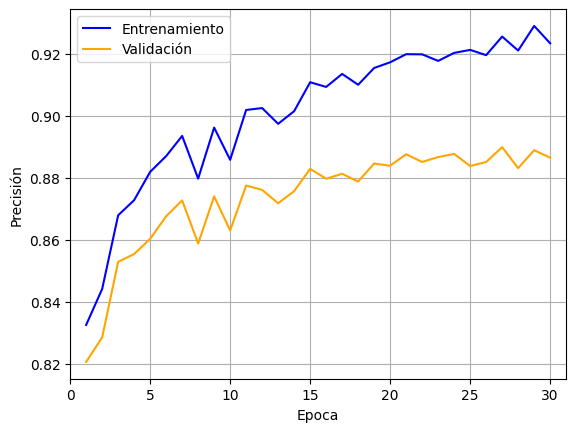

In [69]:
# Cambiamos el learning rate a 1e-1

lr = 1e-1
n1 = 128
n2 = 64
p = 0.2
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


Epoch 1
--------------------
Batch     0 | Loss: 2.283103 | Processed: 0.17%
Batch    60 | Loss: 2.301956 | Processed: 10.17%
Batch   120 | Loss: 2.304655 | Processed: 20.17%
Batch   180 | Loss: 2.304088 | Processed: 30.17%
Batch   240 | Loss: 2.296267 | Processed: 40.17%
Batch   300 | Loss: 2.285152 | Processed: 50.17%
Batch   360 | Loss: 2.312818 | Processed: 60.17%
Batch   420 | Loss: 2.298289 | Processed: 70.17%
Batch   480 | Loss: 2.274215 | Processed: 80.17%
Batch   540 | Loss: 2.277613 | Processed: 90.17%
Validation | Precision: 14.0% | Avg Loss: 2.281570
Validation | Precision: 14.5% | Avg Loss: 2.281221
Epoch 2
--------------------
Batch     0 | Loss: 2.289584 | Processed: 0.17%
Batch    60 | Loss: 2.298633 | Processed: 10.17%
Batch   120 | Loss: 2.277503 | Processed: 20.17%
Batch   180 | Loss: 2.278591 | Processed: 30.17%
Batch   240 | Loss: 2.257038 | Processed: 40.17%
Batch   300 | Loss: 2.287284 | Processed: 50.17%
Batch   360 | Loss: 2.263597 | Processed: 60.17%
Batch   4

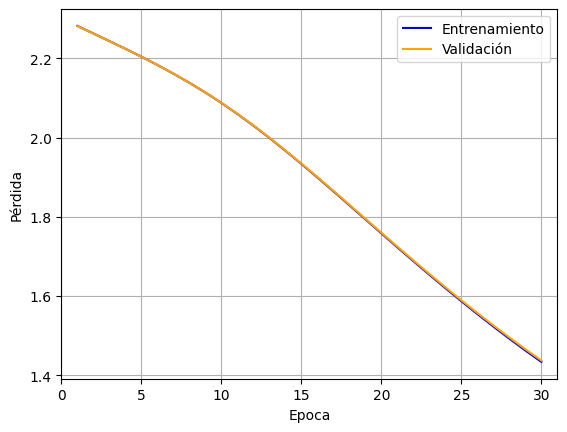

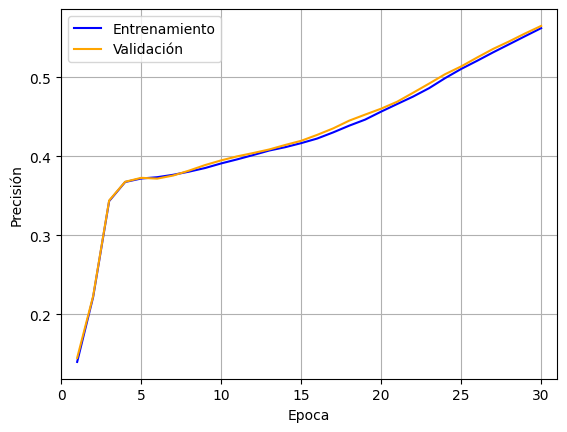

In [13]:
# Cambiamos el learning rate a 1e-4

lr = 1e-4
n1 = 128
n2 = 64
p = 0.2
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.332200 | Processed: 0.17%
Batch    60 | Loss: 2.331687 | Processed: 10.17%
Batch   120 | Loss: 2.331020 | Processed: 20.17%
Batch   180 | Loss: 2.233538 | Processed: 30.17%
Batch   240 | Loss: 2.249234 | Processed: 40.17%
Batch   300 | Loss: 2.242694 | Processed: 50.17%
Batch   360 | Loss: 2.211842 | Processed: 60.17%
Batch   420 | Loss: 2.193865 | Processed: 70.17%
Batch   480 | Loss: 2.200924 | Processed: 80.17%
Batch   540 | Loss: 2.136346 | Processed: 90.17%
Validation | Precision: 36.0% | Avg Loss: 2.136447
Validation | Precision: 36.2% | Avg Loss: 2.136862
Epoch 2
--------------------
Batch     0 | Loss: 2.190450 | Processed: 0.17%
Batch    60 | Loss: 2.198756 | Processed: 10.17%
Batch   120 | Loss: 2.165800 | Processed: 20.17%
Batch   180 | Loss: 2.167353 | Processed: 30.17%
Batch   240 | Loss: 2.104542 | Processed: 40.17%
Batch   300 | Loss: 2.062505 | Processed: 50.17%
Batch   360 | Loss: 2.044307 | Processed: 60.17%
Batch   4

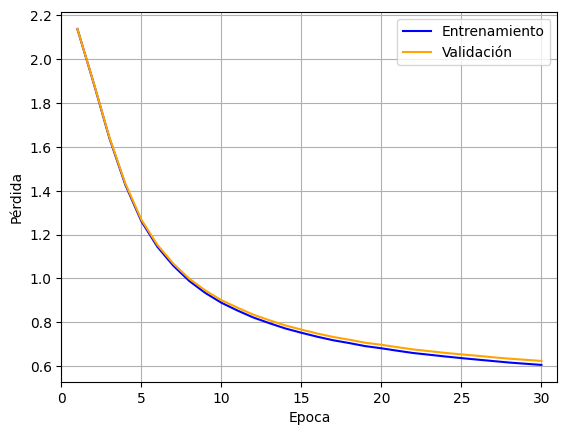

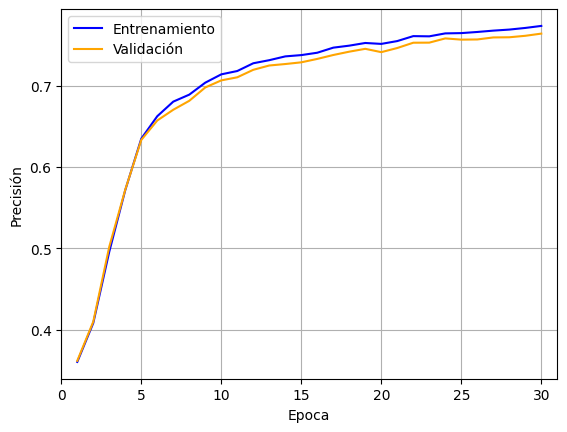

In [14]:
# Cambiamos el dropout a 0.5

lr = 1e-3
n1 = 128
n2 = 64
p = 0.5
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.293873 | Processed: 0.17%
Batch    60 | Loss: 2.291401 | Processed: 10.17%
Batch   120 | Loss: 2.296614 | Processed: 20.17%
Batch   180 | Loss: 2.242124 | Processed: 30.17%
Batch   240 | Loss: 2.238801 | Processed: 40.17%
Batch   300 | Loss: 2.215052 | Processed: 50.17%
Batch   360 | Loss: 2.190731 | Processed: 60.17%
Batch   420 | Loss: 2.178801 | Processed: 70.17%
Batch   480 | Loss: 2.156782 | Processed: 80.17%
Batch   540 | Loss: 2.126198 | Processed: 90.17%
Validation | Precision: 47.3% | Avg Loss: 2.111173
Validation | Precision: 46.7% | Avg Loss: 2.112391
Epoch 2
--------------------
Batch     0 | Loss: 2.124409 | Processed: 0.17%
Batch    60 | Loss: 2.087356 | Processed: 10.17%
Batch   120 | Loss: 2.056562 | Processed: 20.17%
Batch   180 | Loss: 2.011729 | Processed: 30.17%
Batch   240 | Loss: 2.047975 | Processed: 40.17%
Batch   300 | Loss: 1.972608 | Processed: 50.17%
Batch   360 | Loss: 1.931520 | Processed: 60.17%
Batch   4

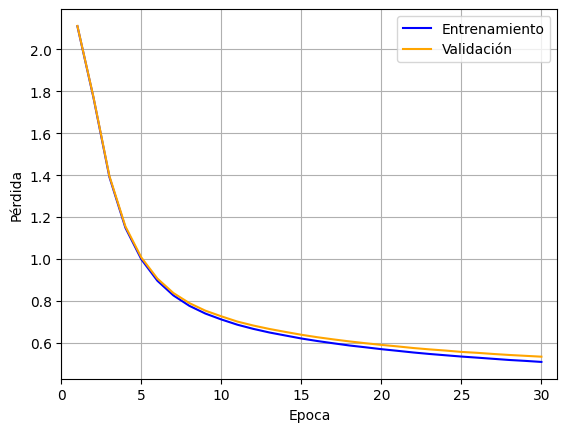

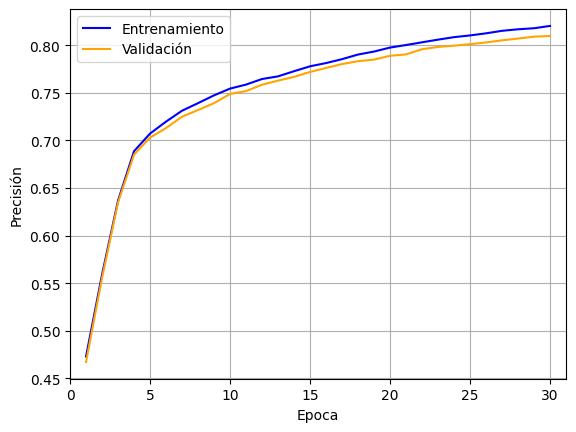

In [15]:
# Elimiamos el dropout

lr = 1e-3
n1 = 128
n2 = 64
p = 0.0
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.317003 | Processed: 0.33%
Batch    30 | Loss: 2.318936 | Processed: 10.33%
Batch    60 | Loss: 2.299966 | Processed: 20.33%
Batch    90 | Loss: 2.293596 | Processed: 30.33%
Batch   120 | Loss: 2.294866 | Processed: 40.33%
Batch   150 | Loss: 2.280299 | Processed: 50.33%
Batch   180 | Loss: 2.267091 | Processed: 60.33%
Batch   210 | Loss: 2.270972 | Processed: 70.33%
Batch   240 | Loss: 2.264822 | Processed: 80.33%
Batch   270 | Loss: 2.256532 | Processed: 90.33%
Validation | Precision: 25.8% | Avg Loss: 2.235609
Validation | Precision: 25.3% | Avg Loss: 2.236343
Epoch 2
--------------------
Batch     0 | Loss: 2.235987 | Processed: 0.33%
Batch    30 | Loss: 2.242777 | Processed: 10.33%
Batch    60 | Loss: 2.223826 | Processed: 20.33%
Batch    90 | Loss: 2.215786 | Processed: 30.33%
Batch   120 | Loss: 2.200896 | Processed: 40.33%
Batch   150 | Loss: 2.197650 | Processed: 50.33%
Batch   180 | Loss: 2.186139 | Processed: 60.33%
Batch   2

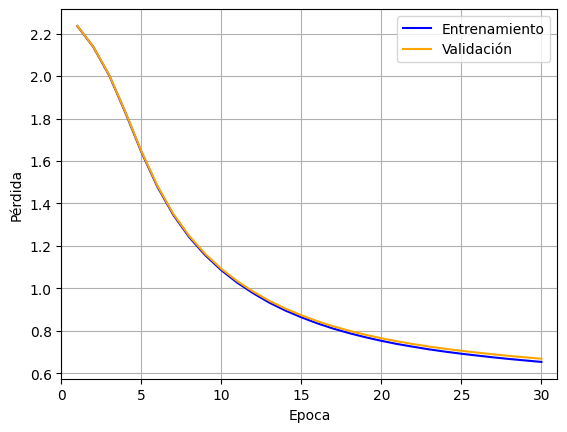

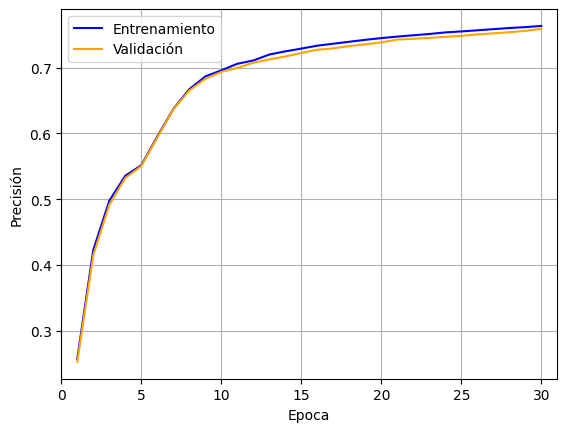

In [ ]:
# Cambiamos el batch size a 200

lr = 1e-3
n1 = 128
n2 = 64
p = 0.2
BATCH_SIZE = 200
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.286401 | Processed: 0.08%
Batch   120 | Loss: 2.294010 | Processed: 10.08%
Batch   240 | Loss: 2.252631 | Processed: 20.08%
Batch   360 | Loss: 2.236653 | Processed: 30.08%
Batch   480 | Loss: 2.138543 | Processed: 40.08%
Batch   600 | Loss: 2.148812 | Processed: 50.08%
Batch   720 | Loss: 2.047461 | Processed: 60.08%
Batch   840 | Loss: 1.984522 | Processed: 70.08%
Batch   960 | Loss: 1.881955 | Processed: 80.08%
Batch  1080 | Loss: 1.923169 | Processed: 90.08%
Validation | Precision: 47.9% | Avg Loss: 1.780732
Validation | Precision: 47.6% | Avg Loss: 1.783547
Epoch 2
--------------------
Batch     0 | Loss: 1.802358 | Processed: 0.08%
Batch   120 | Loss: 1.789793 | Processed: 10.08%
Batch   240 | Loss: 1.716991 | Processed: 20.08%
Batch   360 | Loss: 1.638126 | Processed: 30.08%
Batch   480 | Loss: 1.573429 | Processed: 40.08%
Batch   600 | Loss: 1.523675 | Processed: 50.08%
Batch   720 | Loss: 1.497148 | Processed: 60.08%
Batch   8

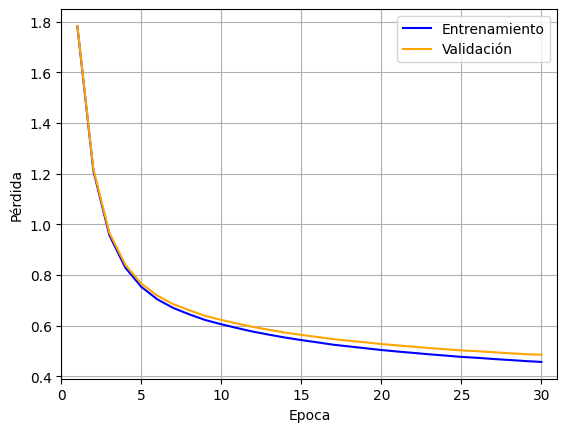

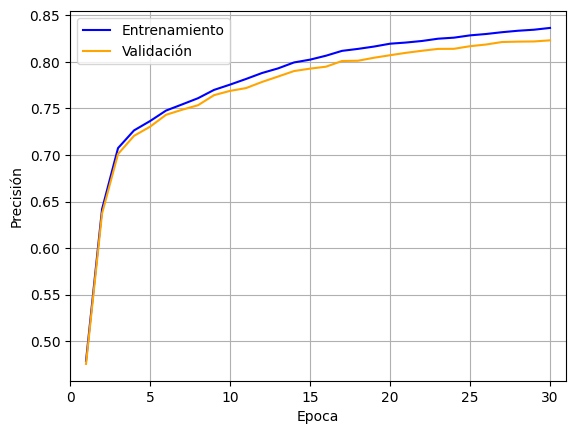

In [9]:
#Cambiamos el batch size a 50

lr = 1e-3
n1 = 128
n2 = 64
p = 0.2
BATCH_SIZE = 50
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.283328 | Processed: 0.17%
Batch    60 | Loss: 2.288548 | Processed: 10.17%
Batch   120 | Loss: 2.282513 | Processed: 20.17%
Batch   180 | Loss: 2.256156 | Processed: 30.17%
Batch   240 | Loss: 2.229330 | Processed: 40.17%
Batch   300 | Loss: 2.206953 | Processed: 50.17%
Batch   360 | Loss: 2.178885 | Processed: 60.17%
Batch   420 | Loss: 2.190315 | Processed: 70.17%
Batch   480 | Loss: 2.153657 | Processed: 80.17%
Batch   540 | Loss: 2.109054 | Processed: 90.17%
Validation | Precision: 48.3% | Avg Loss: 2.092339
Validation | Precision: 48.0% | Avg Loss: 2.093318
Epoch 2
--------------------
Batch     0 | Loss: 2.128098 | Processed: 0.17%
Batch    60 | Loss: 2.078910 | Processed: 10.17%
Batch   120 | Loss: 2.024188 | Processed: 20.17%
Batch   180 | Loss: 2.048311 | Processed: 30.17%
Batch   240 | Loss: 1.984745 | Processed: 40.17%
Batch   300 | Loss: 1.961972 | Processed: 50.17%
Batch   360 | Loss: 1.923888 | Processed: 60.17%
Batch   4

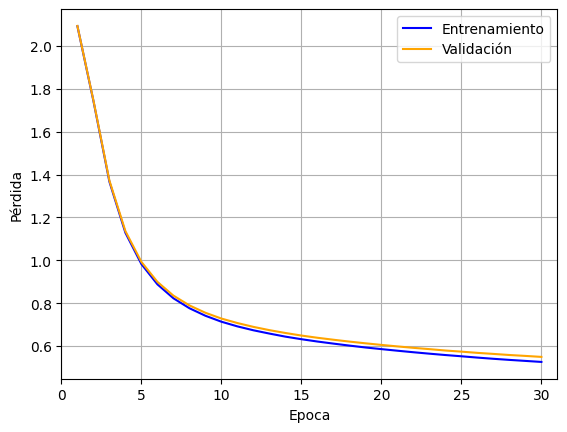

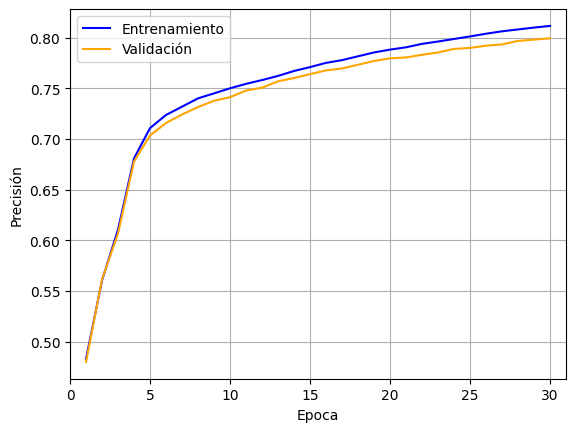

In [11]:
# Cambiamos el numero de neuronas

lr = 1e-3
n1 = 256
n2 = 128
p = 0.2
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

Epoch 1
--------------------
Batch     0 | Loss: 2.332469 | Processed: 0.17%
Batch    60 | Loss: 2.292999 | Processed: 10.17%
Batch   120 | Loss: 2.332743 | Processed: 20.17%
Batch   180 | Loss: 2.275566 | Processed: 30.17%
Batch   240 | Loss: 2.257087 | Processed: 40.17%
Batch   300 | Loss: 2.237553 | Processed: 50.17%
Batch   360 | Loss: 2.259865 | Processed: 60.17%
Batch   420 | Loss: 2.216575 | Processed: 70.17%
Batch   480 | Loss: 2.219676 | Processed: 80.17%
Batch   540 | Loss: 2.213210 | Processed: 90.17%
Validation | Precision: 32.2% | Avg Loss: 2.172586
Validation | Precision: 32.4% | Avg Loss: 2.173146
Epoch 2
--------------------
Batch     0 | Loss: 2.184418 | Processed: 0.17%
Batch    60 | Loss: 2.190996 | Processed: 10.17%
Batch   120 | Loss: 2.129476 | Processed: 20.17%
Batch   180 | Loss: 2.113418 | Processed: 30.17%
Batch   240 | Loss: 2.123762 | Processed: 40.17%
Batch   300 | Loss: 2.050585 | Processed: 50.17%
Batch   360 | Loss: 2.063107 | Processed: 60.17%
Batch   4

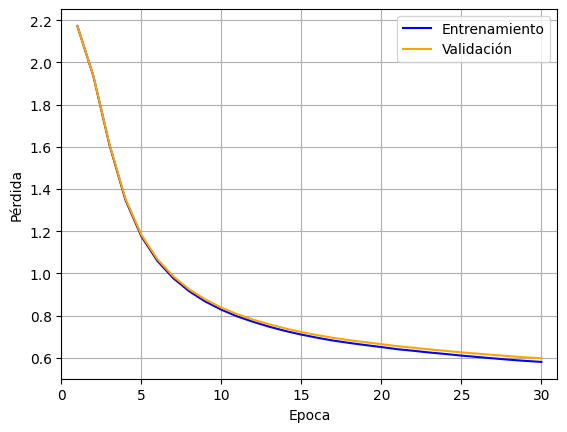

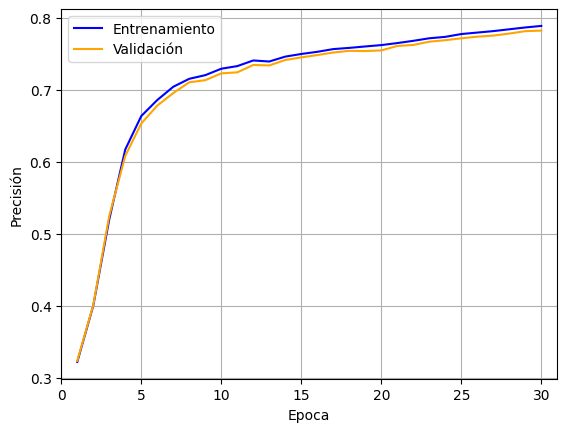

In [13]:
lr = 1e-3
n1 = 64
n2 = 32
p = 0.2
BATCH_SIZE = 100
num_epochs = 30

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model = model.to(device)

list_train_avg_loss_incorrecta   = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta  = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss_incorrecta, train_precision_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_model(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()


plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entrenamiento', c="blue")
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', c="orange")
plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()